# PyTorch Basics
PyTorch is an automatic differentiation framework that, essentially, is your NumPy for machine learning and anything that involves exact derivatives. PyTorch natively supports hardware accelerators, such as GPUs, that can significantly speed up matrix multiplication operations, as well as distributed computing to handle large workloads.

The main element of PyTorch is a tensor, which behaves very similarly to NumPy arrays

In [ ]:
import torch

In [ ]:
tensor1 = torch.rand(2, 3)
tensor2 = torch.rand(2, 3)

In [ ]:
tensor3 = tensor1 @ tensor2.T
tensor3

tensor([[1.3841, 0.2584],
        [1.4727, 0.1718]])

Tensors have `requires_grad` a property that indicates whether gradients should be computed with respect to their values. By default, this is set to `False`.

In [ ]:
tensor1.requires_grad = True
tensor2.requires_grad = True

However, if we set it to `True`, we will be able to compute the gradient of scalar quantities with respect to the tensor.
Let's consider a simple example where we add the sine and cosine of both tensors:
$$\sum_i\sin(a_i) + \cos(b_i)$$

## Derivatives
Recall that $\frac{d}{dx}\sin(x) = \cos(x)$ and $\frac{d}{dx}\cos(x) = -\sin(x)$.


In [ ]:
value = torch.sum(torch.sin(tensor1) + torch.cos(tensor2))
value.backward()

The result of the sum, `value`, is also a tensor.
When we call the `backward` method, it computes the gradient over all the tensors that have been involved in its calculation.
The resulting gradients are stored in the tensors themselves.

In [ ]:
tensor1.grad, tensor2.grad

(tensor([[0.5658, 0.9934, 0.9035],
         [0.9667, 0.7606, 0.7177]]),
 tensor([[-0.8308, -0.7944, -0.6745],
         [-0.2316, -0.1101, -0.0433]]))

In [ ]:
torch.sin(tensor1), torch.cos(tensor2)

(tensor([[0.8245, 0.1149, 0.4285],
         [0.2559, 0.6492, 0.6964]], grad_fn=<SinBackward0>),
 tensor([[0.5566, 0.6073, 0.7382],
         [0.9728, 0.9939, 0.9991]], grad_fn=<CosBackward0>))

## Zero out gradients

Subsequent gradient computations with respect to the same tensor will add the new gradient to the previous one. We must take this into account and reset the gradients manually when needed. In machine learning applications, we hardly ever zero out gradients at the tensor level.
We typically rely on the `zero_grad()` method from either our [optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) or [module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to reset the gradients.
See [the docs](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html) for further details.

To reset the gradients of a tensor, we can manually set them to `None` or zero.

In [ ]:
tensor1.grad.zero_()

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
tensor1.grad

tensor([[0., 0., 0.],
        [0., 0., 0.]])

# Basics of Neural Network

### Task and data

Use the MNIST dataset, which is composed of hand-written digit images from 0 to 9. The task is to classify those images into their respective digits.

In [35]:
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

### Extract Dataset from MNIST

In [34]:
train_data = MNIST(root='data/', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='data/', train=False, download=True, transform=ToTensor())

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 121802176.27it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 19690457.38it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 77382334.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5785159.05it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Plot Train and Test Samples

In [39]:
def plot_examples(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")

    plt.show()

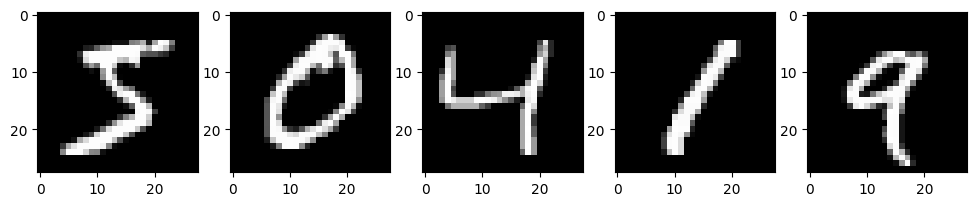

In [40]:
plot_examples(train_data)

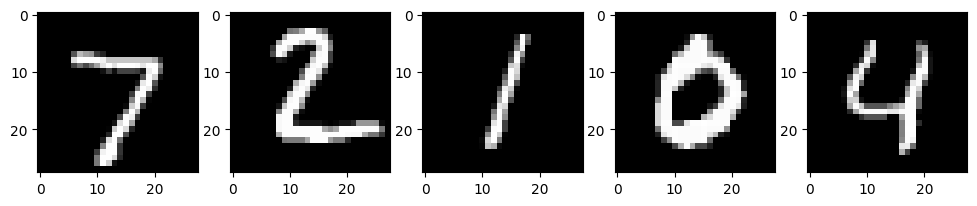

In [41]:
plot_examples(test_data)

### Split train-eval

In [139]:
train_size = int(len(train_data) * 0.8)  # 80% for training
eval_size = len(train_data) - train_size  # 20% for evaluation

train_data, eval_data = random_split(train_data, [train_size, eval_size])

### DataLoader

In [140]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Loss Function

In order to train any model, we need to be able to evalute its performance on the given task.
This performance measure must be a smooth function that is typically referred to as **loss function**.
The learning process will aim to minimize the loss function, as introduced in the [learning as an optimization task](https://borjarequena.github.io/Neural-Network-Course/course/introduction.html#learning-as-an-optimization-task) section from the introductory chapter.

In this case, we have a classification problem with ten classes (digits from 0 to 9).
Therefore, we will use the cross-entropy loss function $$\mathcal{L}_{\text{CE}} = -\frac{1}{n}\sum_i^n \mathbf{y}_i^T\log(f(\mathbf{x}_i))\,,$$ where $\mathbf{y}_i$ is the one-hot-encoding vector of the true label, and $f(\mathbf{x}_i)$ provides the predicted probability for sample $\mathbf{x}_i$ to belong to each of the classes.

In [141]:
def cross_entropy_loss(y_pred, y_true):
    target_preds = y_pred[torch.arange(len(y_pred)), y_true]
    return -torch.mean(torch.log(target_preds))

In [142]:
def accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true).float().mean()

### Model

The last ingredient for our learning task is a model that will encode the program to solve the task.
In this case, we will start with a simple **fully-connected neural network**.
In these networks, we distinguish between three types of layers:

- The *input layer* contains the data values. In this case, it will be the pixel values.
- The *output layer* contains the desired output. In this case, the probability for each class.
- The *hidden layers* are all the layers between the input and output layers.

Individual neurons perform simple calculations based on the signal received from by the neurons from the preceding layer.
Typically, they perform a linear transformation followed by a non-linear *activation function* $\xi$ of the form.
\begin{split}
    z &= \mathbf{\omega}^T \mathbf{x} + b = \sum_i \omega_i x_i + b\\
    x &= \xi(z)\,.
\end{split}
Here, $\mathbf{x}$ denotes the activations of the neurons in the preceding layer, and the connection strength between each of those neurons is encoded in the *weight* vector $\mathbf{\omega}$.
The neuron incorporates a bias $b$, and the resulting value of the linear transformation $z$ is known as the *logit*.
Finally, the resulting activation of the neuron $x$ is determined by applying the non-linear activation function $\xi$.

We will start by initializing the parameters for our linear operations.

In [143]:
input_size = 28 * 28
hidden_size = 500
n_classes = 10

In [144]:
# Input to hidden
W1 = torch.randn(input_size, hidden_size) / torch.sqrt(torch.tensor(input_size))
W1.requires_grad_()
b = torch.zeros(hidden_size, requires_grad=True)

# Hidden to output
W2 = torch.randn(hidden_size, n_classes) / torch.sqrt(torch.tensor(hidden_size))
W2.requires_grad_();

### Activation Function

The activation functions can take any form, so long as it is non-linear, and they can be used to obtain the desired output.
In this case, we will use the rectified linear unit (ReLU) activation function in the hidden layer $$\text{ReLU}(z) = \max(0, z)\,,$$ and a softmax activation function in the output layer to normalize the logits as a probability distribution $$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_k e^{z_k}}\,.$$

In [145]:
def relu(x):
    return torch.maximum(torch.zeros_like(x), x)

In [146]:
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdim=True)

### Fully Connected Network from Scratch

In [147]:
def model(x):
    x = x.reshape(-1, input_size)
    z = x @ W1 + b
    x = relu(z)
    z = x @ W2
    return softmax(z)

### Training

The typical learning procedure is:

1. For every training batch
    - Evaluate the model
    - Compute the loss
    - Compute the gradients of the parameters
    - Update the parameters

2. For every validation batch
    - Evaluate the model
    - Compute the loss

3. Repeat 1 and 2 for every training epoch

In [148]:
def compute_loss_and_accuracy(loader, lr=0.001, data_type="train"):
  epoch_accuracy = []
  epoch_true = []
  epoch_pred = []
  epoch_loss = 0

  for x, y_true in loader:
      y_pred = model(x)
      loss = cross_entropy_loss(y_pred, y_true)

      if data_type == "train":
        loss.backward() #Back propagation

        #Gradient-descent part
        with torch.no_grad():
            #update weights and biases
            W1.data -= lr * W1.grad
            W2.data -= lr * W2.grad
            b.data -= lr * b.grad

            #reset weights and biases
            W1.grad.zero_()
            W2.grad.zero_()
            b.grad.zero_()

      epoch_loss += loss.item()
      epoch_true.append(y_true)
      epoch_pred.append(y_pred)

  epoch_accuracy = accuracy(torch.cat(epoch_pred), torch.cat(epoch_true))

  return epoch_loss/len(loader), epoch_accuracy

In [149]:
def train_model(epochs=10, lr=0.001):
  train_losses = []
  train_accuracies = []

  eval_losses = []
  eval_accuracies = []

  for epoch in range(epochs):
    train_loss, train_accuracy = compute_loss_and_accuracy(train_loader, lr)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    eval_loss, eval_accuracy = compute_loss_and_accuracy(eval_loader, lr, data_type="eval")
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

    print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

  return train_losses, train_accuracies, eval_losses, eval_accuracies

In [150]:
train_loss, train_accuracy, eval_loss, eval_accuracy = train_model(epochs=30, lr=0.001)

Epoch: 0
Train Loss: 2.0042, Train Accuracy: 0.4798
Eval Loss: 1.7148, Eval Accuracy: 0.7036
Epoch: 1
Train Loss: 1.4731, Train Accuracy: 0.7497
Eval Loss: 1.2627, Eval Accuracy: 0.7751
Epoch: 2
Train Loss: 1.1071, Train Accuracy: 0.7976
Eval Loss: 0.9818, Eval Accuracy: 0.8070
Epoch: 3
Train Loss: 0.8876, Train Accuracy: 0.8229
Eval Loss: 0.8151, Eval Accuracy: 0.8301
Epoch: 4
Train Loss: 0.7540, Train Accuracy: 0.8398
Eval Loss: 0.7101, Eval Accuracy: 0.8435
Epoch: 5
Train Loss: 0.6670, Train Accuracy: 0.8507
Eval Loss: 0.6394, Eval Accuracy: 0.8544
Epoch: 6
Train Loss: 0.6064, Train Accuracy: 0.8595
Eval Loss: 0.5884, Eval Accuracy: 0.8618
Epoch: 7
Train Loss: 0.5618, Train Accuracy: 0.8654
Eval Loss: 0.5503, Eval Accuracy: 0.8684
Epoch: 8
Train Loss: 0.5277, Train Accuracy: 0.8704
Eval Loss: 0.5208, Eval Accuracy: 0.8721
Epoch: 9
Train Loss: 0.5007, Train Accuracy: 0.8750
Eval Loss: 0.4972, Eval Accuracy: 0.8763
Epoch: 10
Train Loss: 0.4787, Train Accuracy: 0.8786
Eval Loss: 0.4776

### Plot Loss and Accuracy

In [151]:
def plot_metrics(train_metric, eval_metric, metric_type="Loss"):
  plt.plot(train_metric, label=f"Training {metric_type}")
  plt.plot(eval_metric, label=f"Evaluation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(f"{metric_type}")
  plt.grid()
  plt.legend()

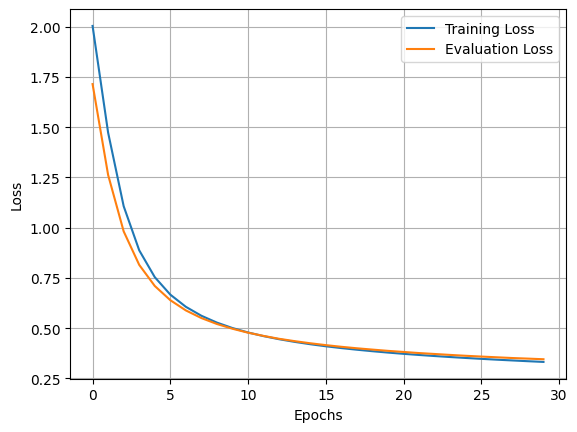

In [152]:
plot_metrics(train_loss, eval_loss)

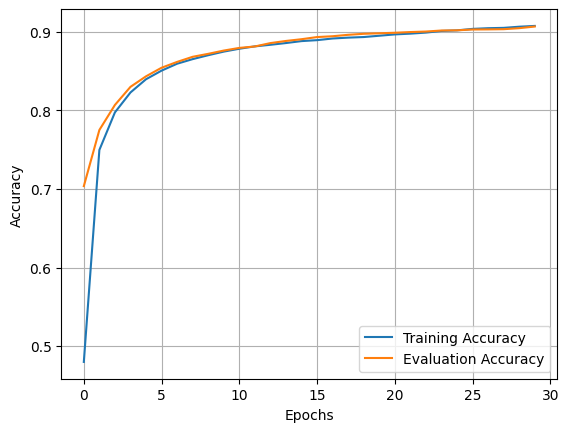

In [153]:
plot_metrics(train_accuracy, eval_accuracy, metric_type="Accuracy")

## Fully Connected Network using PyTorch


In [154]:
import torch.nn as nn
import torch.nn.functional as F

In [174]:
class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        z = self.linear_1(x)
        x = F.relu(z)
        z = self.linear_2(x)
        return z  # Notice we do not implement the softamx activation

model_torch = FullyConnected(28 * 28, 500, 10)

In [175]:
def compute_loss_and_accuracy_torch(model, optimizer, loader, lr=0.001, data_type="train"):
  epoch_accuracy = []
  epoch_true = []
  epoch_pred = []
  epoch_loss = 0

  for x, y_true in loader:
      logits = model(x)
      loss = F.cross_entropy(logits, y_true)
      y_pred = F.softmax(logits, dim=1)

      if data_type == "train":
        loss.backward() #Back propagation
        optimizer.step()
        optimizer.zero_grad()

      epoch_loss += loss.item()
      epoch_true.append(y_true)
      epoch_pred.append(y_pred)

  epoch_accuracy = accuracy(torch.cat(epoch_pred), torch.cat(epoch_true))

  return epoch_loss/len(loader), epoch_accuracy

In [176]:
def train_model_torch(model, epochs=10, lr=0.001):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  train_losses = []
  train_accuracies = []

  eval_losses = []
  eval_accuracies = []

  for epoch in range(epochs):
    train_loss, train_accuracy = compute_loss_and_accuracy_torch(model, optimizer, train_loader, lr)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    eval_loss, eval_accuracy = compute_loss_and_accuracy_torch(model, optimizer, eval_loader, lr, data_type="eval")
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

    print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

  return train_losses, train_accuracies, eval_losses, eval_accuracies

In [177]:
train_loss, train_accuracy, eval_loss, eval_accuracy = train_model_torch(model_torch, epochs=30, lr=0.001)

Epoch: 0
Train Loss: 2.1901, Train Accuracy: 0.3768
Eval Loss: 2.0715, Eval Accuracy: 0.5796
Epoch: 1
Train Loss: 1.9323, Train Accuracy: 0.6686
Eval Loss: 1.7787, Eval Accuracy: 0.7135
Epoch: 2
Train Loss: 1.6152, Train Accuracy: 0.7411
Eval Loss: 1.4500, Eval Accuracy: 0.7526
Epoch: 3
Train Loss: 1.3050, Train Accuracy: 0.7741
Eval Loss: 1.1721, Eval Accuracy: 0.7836
Epoch: 4
Train Loss: 1.0661, Train Accuracy: 0.8012
Eval Loss: 0.9752, Eval Accuracy: 0.8066
Epoch: 5
Train Loss: 0.9012, Train Accuracy: 0.8192
Eval Loss: 0.8412, Eval Accuracy: 0.8246
Epoch: 6
Train Loss: 0.7880, Train Accuracy: 0.8330
Eval Loss: 0.7481, Eval Accuracy: 0.8374
Epoch: 7
Train Loss: 0.7076, Train Accuracy: 0.8436
Eval Loss: 0.6803, Eval Accuracy: 0.8467
Epoch: 8
Train Loss: 0.6482, Train Accuracy: 0.8509
Eval Loss: 0.6297, Eval Accuracy: 0.8543
Epoch: 9
Train Loss: 0.6027, Train Accuracy: 0.8579
Eval Loss: 0.5896, Eval Accuracy: 0.8595
Epoch: 10
Train Loss: 0.5667, Train Accuracy: 0.8627
Eval Loss: 0.5580

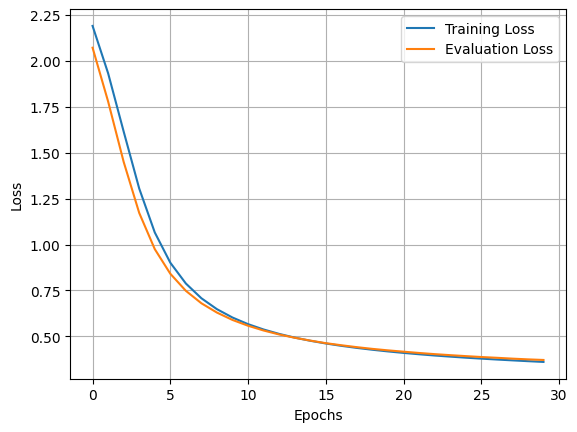

In [178]:
plot_metrics(train_loss, eval_loss)

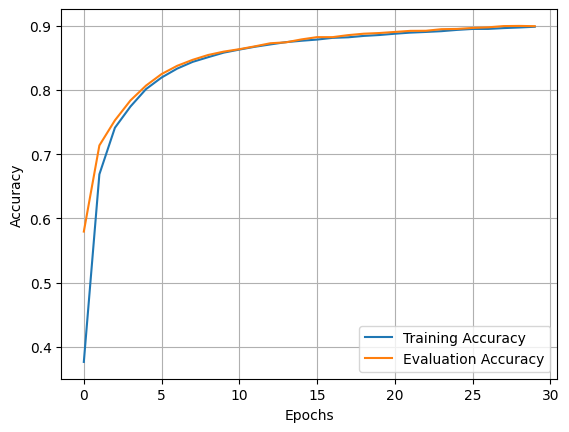

In [179]:
plot_metrics(train_accuracy, eval_accuracy, metric_type="Accuracy")